In [1]:
import MySQLdb as mysql
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway,spearmanr
%matplotlib inline

/Users/mikesivley/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
with open('/Users/mikesivley/pdbmap/data/cath/cath-names-v4_1_0.txt','rb') as fin:
    cathnames = pd.read_csv(fin,sep='\t',skiprows=16,names=['CATH','acc','name'])

In [3]:
con = mysql.connect("chgr2.accre.vanderbilt.edu","sivleyrm","global-trifecta","ripleysK_results")

In [4]:
sql = """SELECT a.unp,a.pdbid,a.chain,nresidues,nsnvs,t,k,p,z,q,CATH
            FROM pdb_exac_missense_univariate a 
            inner join pdbmap_supp.cath b
            on a.pdbid=b.pdbid and a.chain=b.chain and a.unp=b.uniprot_acc"""
df   = pd.read_sql(sql,con)
print "Protein chains analyzed: %d"%len(df.drop_duplicates(['pdbid','chain']))
ln   = len(df.drop_duplicates(['pdbid','chain']))
df   = df[df["CATH"]!='']
df   = df.merge(cathnames,on="CATH")
df["name"] = df["name"].apply(lambda x: x.lstrip(":"))
msg  = "%d chains were removed because they were not "
msg += "CATH-classified. %d remaining."
msg  = msg%(ln-len(df.drop_duplicates(['pdbid','chain'])),
                len(df.drop_duplicates(['pdbid','chain'])))
print msg
ln   = len(df.drop_duplicates(['pdbid','chain']))
df   = df.groupby("CATH").filter(lambda x: len(x)>=10)
msg  = "%d chains were removed because they were in a "
msg += "CATH class of size <10. %d remaining."
msg  = msg%(ln-len(df.drop_duplicates(['pdbid','chain'])),
                len(df.drop_duplicates(['pdbid','chain'])))

print msg
# Get the CATH identifiers
cath  = list(df["CATH"].drop_duplicates())
cathn = list(df.drop_duplicates("CATH")["name"])
print df.groupby('name').apply(len).sort_values(ascending=False)

Protein chains analyzed: 4490
1760 chains were removed because they were not CATH-classified. 2730 remaining.
23 chains were removed because they were in a CATH class of size <10. 2707 remaining.
name
Orthogonal Bundle        567
3-Layer(aba) Sandwich    563
2-Layer Sandwich         531
Roll                     390
Sandwich                 364
Up-down Bundle           180
Alpha-Beta Complex       172
Beta Barrel              146
Alpha Horseshoe           61
Ribbon                    60
Alpha-Beta Barrel         55
Irregular                 38
Beta Complex              23
4-Layer Sandwich          19
Trefoil                   17
7 Propellor               17
Alpha-Beta Horseshoe      14
3-Layer(bba) Sandwich     10
dtype: int64


In [6]:
print "NOTE: Some structure chains are annotated with >1 Tier-2 CATH classification"
print len(df.drop_duplicates(["pdbid","chain"]))
print len(df.drop_duplicates(["pdbid","chain","CATH"]))
print "\nNOTE: Some proteins are annotated with >1 Tier-2 CATH classification"
print len(df.drop_duplicates("unp"))
print len(df.drop_duplicates(["unp","CATH"]))
print "\nThe following stratification allows for proteins to appear in multiple classes"

NOTE: Some structure chains are annotated with >1 Tier-2 CATH classification
2707
3227

NOTE: Some proteins are annotated with >1 Tier-2 CATH classification
2394
3049

The following stratification allows for proteins to appear in multiple classes


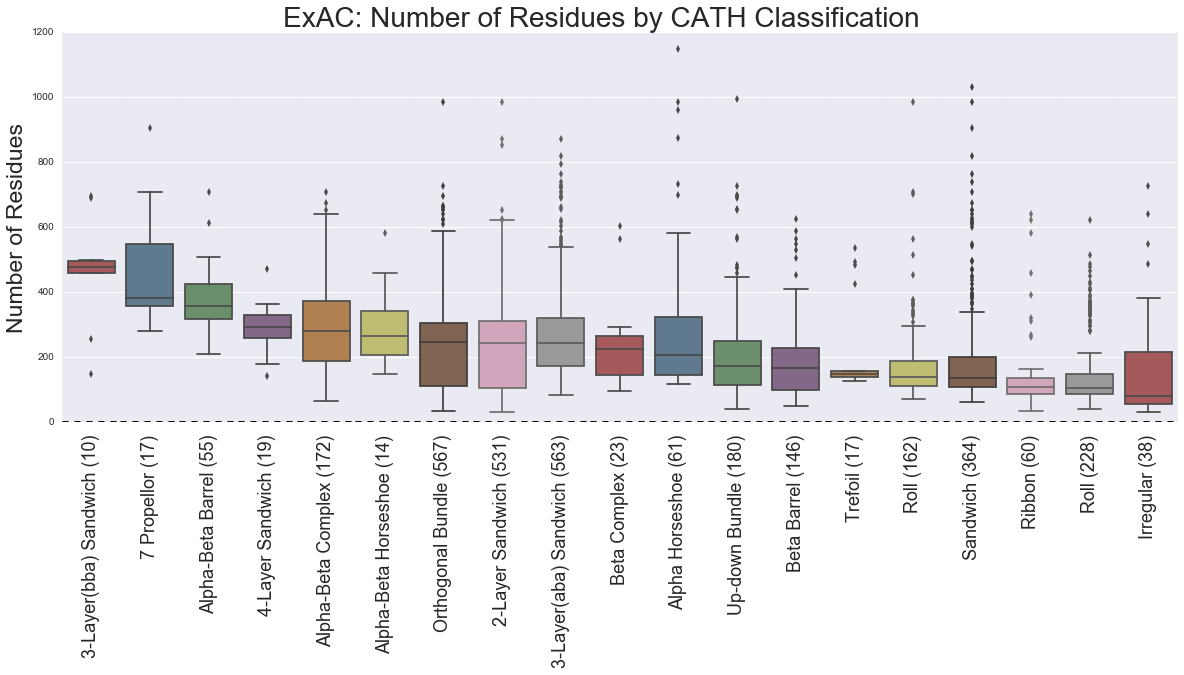

ANOVA: F=22.8; p=4.36e-71


In [20]:
# Plot the stratification for number of residues.
fig,ax = plt.subplots(1,len(cath),figsize=(20,7),sharey=True,facecolor='white')
plt.subplots_adjust(wspace=0, hspace=0)
pal = list(sns.color_palette("Set1", n_colors=len(cath), desat=.5))

subs  = [df.ix[df["CATH"]==cath[i],"nresidues"] for i in range(len(cath))]
subs,cath,cathn = zip(*sorted(zip(subs,cath,cathn),key=lambda x: np.median(x[0]),reverse=True))
for i,s in enumerate(subs):
    # Boxplot for each CATH class
    sns.boxplot(s,color=pal[i],ax=ax[i],orient='vertical')
    ax[i].set_xlabel("%s (%d)"%(cathn[i],len(s)),fontsize=18,rotation='vertical')
    ax[i].set_ylabel("")
    
plt.rcParams['xtick.labelsize'] = 20
ax[0].set_ylabel("Number of Residues",fontsize=23)
for x in ax:
    x.axhline(y=0,c='k',ls='dashed',lw=3)
plt.suptitle("ExAC: Number of Residues by CATH Classification",fontsize=28,y=0.95)
plt.show()

print "ANOVA: F=%g; p=%.3g"%f_oneway(*subs)

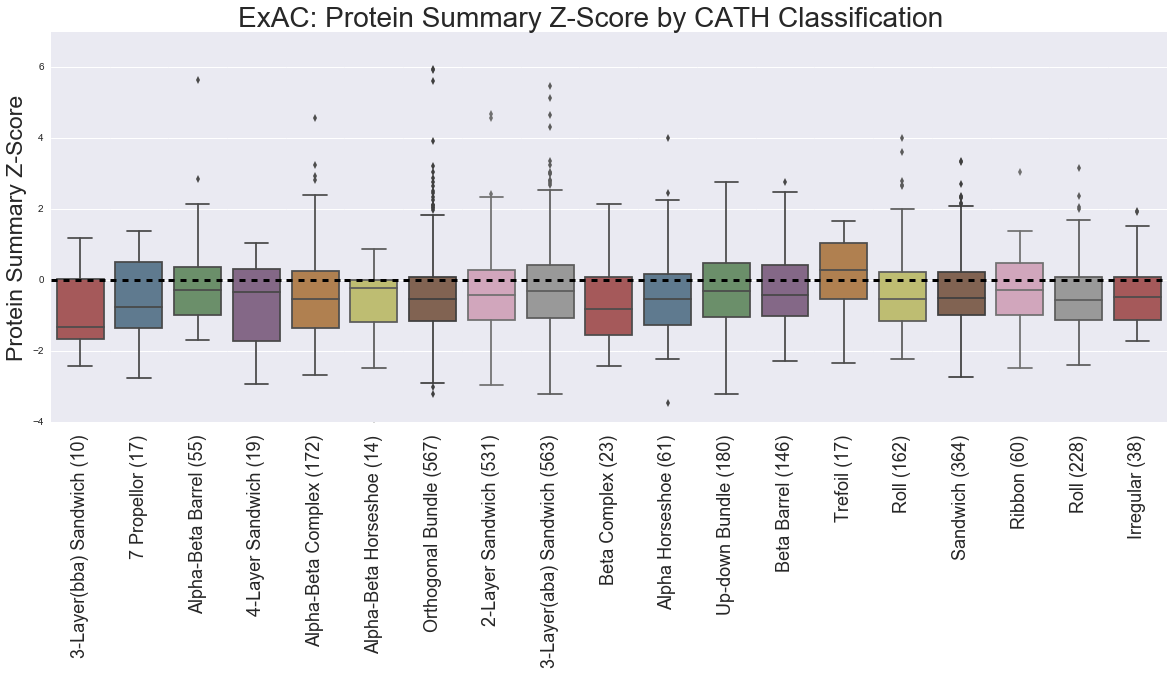


~4 outliers not shown.
ANOVA: F=1.88885; p=0.0129


In [16]:
# Setup the plot
fig,ax = plt.subplots(1,len(cath),figsize=(20,7),sharey=True,facecolor='white')
plt.subplots_adjust(wspace=0, hspace=0)
pal = list(sns.color_palette("Set1", n_colors=len(cath), desat=.5))

subs = [df.ix[df["CATH"]==cath[i],"z"] for i in range(len(cath))]
for i,s in enumerate(subs):
    # Boxplot for each CATH class
    sns.boxplot(s,color=pal[i],ax=ax[i],orient='vertical')
    ax[i].set_xlabel("%s (%d)"%(cathn[i],len(s)),fontsize=18,rotation='vertical')
    ax[i].set_ylabel("")
    ax[i].set_ylim([-4,7])
    
plt.rcParams['xtick.labelsize'] = 20
ax[0].set_ylabel("Protein Summary Z-Score",fontsize=23)
for x in ax:
    x.axhline(y=0,c='k',ls='dashed',lw=3)
plt.suptitle("ExAC: Protein Summary Z-Score by CATH Classification",fontsize=28,y=0.95)
plt.show()

print "\n~4 outliers not shown."
print "ANOVA: F=%g; p=%.3g"%f_oneway(*subs)

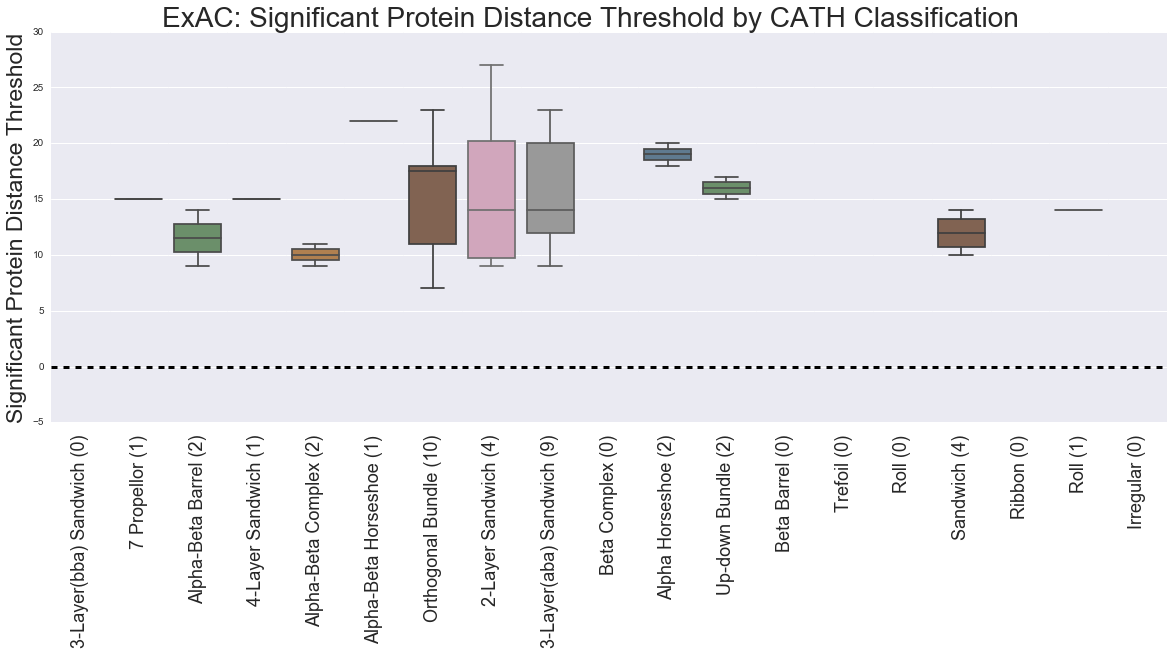


~4 outliers not shown.
ANOVA: F=0.753478; p=0.68


In [17]:
# Setup the plot
fig,ax = plt.subplots(1,len(cath),figsize=(20,7),sharey=True,facecolor='white')
plt.subplots_adjust(wspace=0, hspace=0)
pal = list(sns.color_palette("Set1", n_colors=len(cath), desat=.5))

subs = [df.ix[(df["CATH"]==cath[i]) & (df["q"]<0.1),"t"] for i in range(len(cath))]
for i,s in enumerate(subs):
    # Boxplot for each CATH class
    sns.boxplot(s,color=pal[i],ax=ax[i],orient='vertical')
    ax[i].set_xlabel("%s (%d)"%(cathn[i],len(s)),fontsize=18,rotation='vertical')
    ax[i].set_ylabel("")
    
plt.rcParams['xtick.labelsize'] = 20
ax[0].set_ylabel("Significant Protein Distance Threshold",fontsize=23)
for x in ax:
    x.axhline(y=0,c='k',ls='dashed',lw=3)
plt.suptitle("ExAC: Significant Protein Distance Threshold by CATH Classification",fontsize=28,y=0.95)
plt.show()

print "\n~4 outliers not shown."
print "ANOVA: F=%g; p=%.3g"%f_oneway(*[s.dropna() for s in subs if len(s.dropna())])

In [18]:
# COSMIC
sql = """SELECT a.unp,a.pdbid,a.chain,nresidues,nsnvs,t,k,p,z,q,CATH
            FROM pdb_cosmic_missense_univariate a 
            inner join pdbmap_supp.cath b
            on a.pdbid=b.pdbid and a.chain=b.chain and a.unp=b.uniprot_acc"""
df   = pd.read_sql(sql,con)
print "Protein chains analyzed: %d"%len(df.drop_duplicates(['pdbid','chain']))
ln   = len(df.drop_duplicates(['pdbid','chain']))
df   = df[df["CATH"]!='']
msg  = "%d chains were removed because they were not "
msg += "CATH-classified. %d remaining."
msg  = msg%(ln-len(df.drop_duplicates(['pdbid','chain'])),
                len(df.drop_duplicates(['pdbid','chain'])))
print msg
ln   = len(df.drop_duplicates(['pdbid','chain']))
df   = df.groupby("CATH").filter(lambda x: len(x)>=10)
msg  = "%d chains were removed because they were in a "
msg += "CATH class of size <10. %d remaining."
msg  = msg%(ln-len(df.drop_duplicates(['pdbid','chain'])),
                len(df.drop_duplicates(['pdbid','chain'])))
print msg

Protein chains analyzed: 4526
1778 chains were removed because they were not CATH-classified. 2748 remaining.
22 chains were removed because they were in a CATH class of size <10. 2726 remaining.


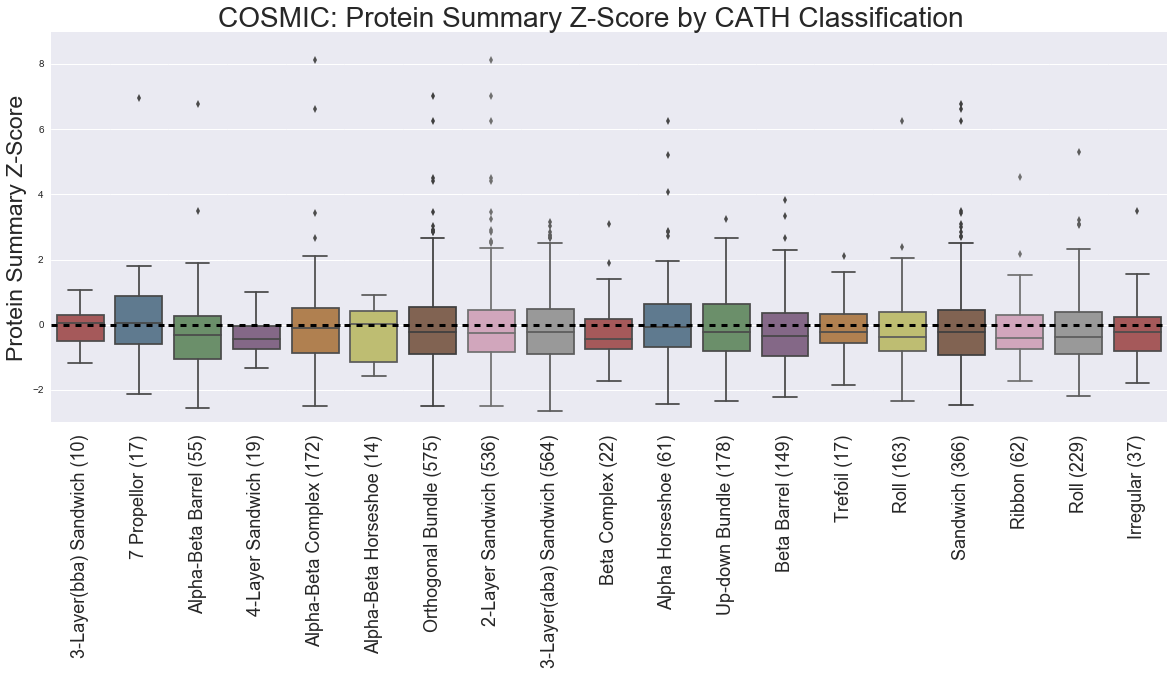


~2 outliers not shown.
ANOVA: F=0.758542; p=0.751


In [19]:
# Setup the plot
fig,ax = plt.subplots(1,len(cath),figsize=(20,7),sharey=True,facecolor='white')
plt.subplots_adjust(wspace=0, hspace=0)
pal = list(sns.color_palette("Set1", n_colors=len(cath), desat=.5))

subs = [df.ix[df["CATH"]==cath[i],"z"] for i in range(len(cath))]
for i,s in enumerate(subs):
    # Boxplot for each CATH class
    sns.boxplot(s,color=pal[i],ax=ax[i],orient='vertical')
    ax[i].set_xlabel("%s (%d)"%(cathn[i],len(s)),fontsize=18,rotation='vertical')
    ax[i].set_ylabel("")
    ax[i].set_ylim([-3,9])
    
plt.rcParams['xtick.labelsize'] = 20
ax[0].set_ylabel("Protein Summary Z-Score",fontsize=23)
for x in ax:
    x.axhline(y=0,c='k',ls='dashed',lw=3)
plt.suptitle("COSMIC: Protein Summary Z-Score by CATH Classification",fontsize=28,y=0.95)
plt.show()

print "\n~2 outliers not shown."
print "ANOVA: F=%g; p=%.3g"%f_oneway(*[s.dropna() for s in subs if len(s.dropna())])

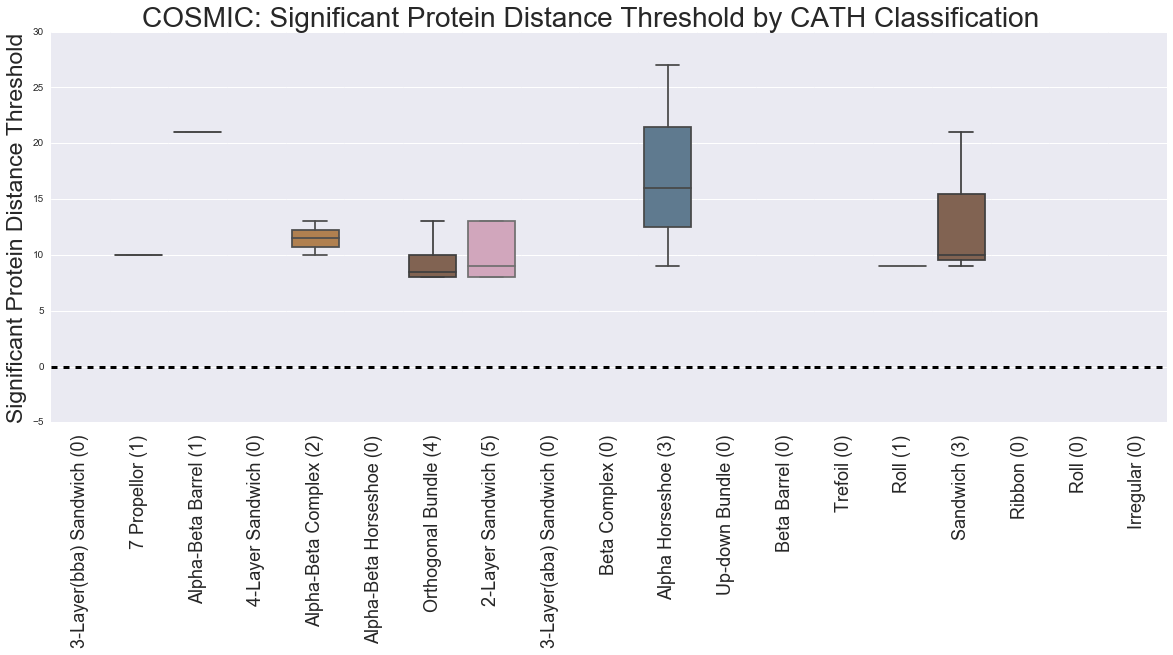


~4 outliers not shown.
ANOVA: F=1.28197; p=0.336


In [20]:
# Setup the plot
fig,ax = plt.subplots(1,len(cath),figsize=(20,7),sharey=True,facecolor='white')
plt.subplots_adjust(wspace=0, hspace=0)
pal = list(sns.color_palette("Set1", n_colors=len(cath), desat=.5))

subs = [df.ix[(df["CATH"]==cath[i]) & (df["q"]<0.1),"t"] for i in range(len(cath))]
for i,s in enumerate(subs):
    # Boxplot for each CATH class
    sns.boxplot(s,color=pal[i],ax=ax[i],orient='vertical')
    ax[i].set_xlabel("%s (%d)"%(cathn[i],len(s)),fontsize=18,rotation='vertical')
    ax[i].set_ylabel("")
    
plt.rcParams['xtick.labelsize'] = 20
ax[0].set_ylabel("Significant Protein Distance Threshold",fontsize=23)
for x in ax:
    x.axhline(y=0,c='k',ls='dashed',lw=3)
plt.suptitle("COSMIC: Significant Protein Distance Threshold by CATH Classification",fontsize=28,y=0.95)
plt.show()

print "\n~4 outliers not shown."
print "ANOVA: F=%g; p=%.3g"%f_oneway(*[s.dropna() for s in subs if len(s.dropna())])

In [21]:
# ClinVar
sql = """SELECT a.unp,a.pdbid,a.chain,nresidues,nsnvs,t,k,p,z,q,CATH
            FROM pdb_clinvar_missense_univariate a 
            inner join pdbmap_supp.cath b
            on a.pdbid=b.pdbid and a.chain=b.chain and a.unp=b.uniprot_acc"""
df   = pd.read_sql(sql,con)
print "Protein chains analyzed: %d"%len(df.drop_duplicates(['pdbid','chain']))
ln   = len(df.drop_duplicates(['pdbid','chain']))
df   = df[df["CATH"]!='']
msg  = "%d chains were removed because they were not "
msg += "CATH-classified. %d remaining."
msg  = msg%(ln-len(df.drop_duplicates(['pdbid','chain'])),
                len(df.drop_duplicates(['pdbid','chain'])))
print msg
ln   = len(df.drop_duplicates(['pdbid','chain']))
df   = df.groupby("CATH").filter(lambda x: len(x)>=10)
msg  = "%d chains were removed because they were in a "
msg += "CATH class of size <10. %d remaining."
msg  = msg%(ln-len(df.drop_duplicates(['pdbid','chain'])),
                len(df.drop_duplicates(['pdbid','chain'])))
print msg

Protein chains analyzed: 450
163 chains were removed because they were not CATH-classified. 287 remaining.
16 chains were removed because they were in a CATH class of size <10. 271 remaining.


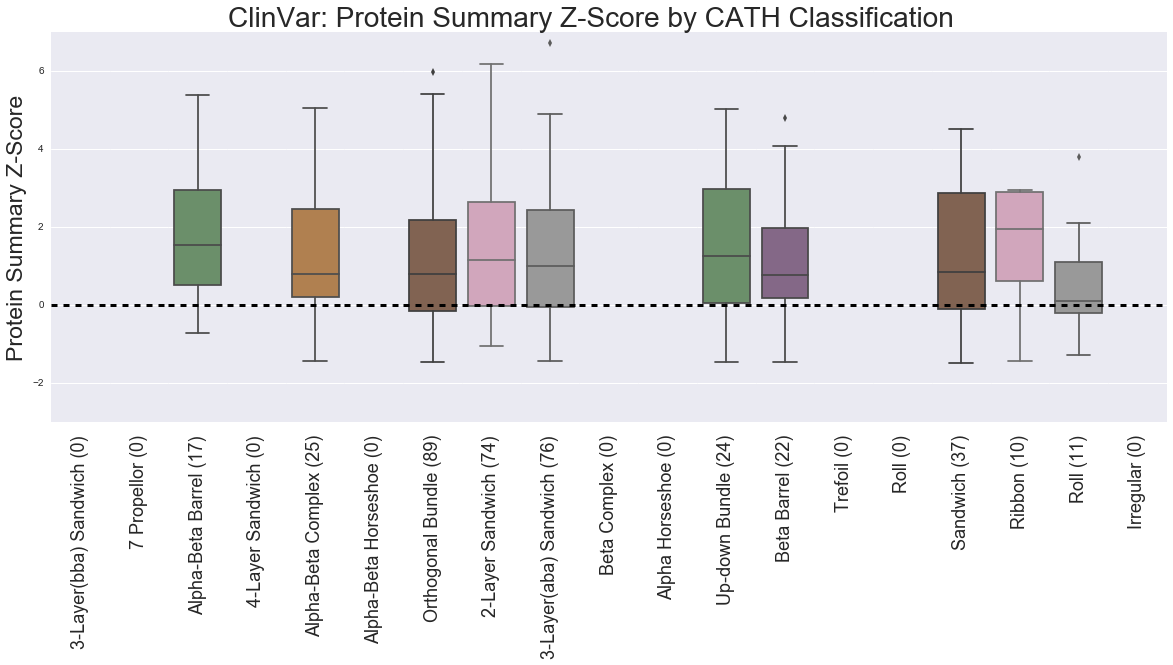


~10 outliers not shown.
ANOVA: F=0.565076; p=0.826


In [22]:
# Setup the plot
fig,ax = plt.subplots(1,len(cath),figsize=(20,7),sharey=True,facecolor='white')
plt.subplots_adjust(wspace=0, hspace=0)
pal = list(sns.color_palette("Set1", n_colors=len(cath), desat=.5))

subs = [df.ix[df["CATH"]==cath[i],"z"] for i in range(len(cath))]
for i,s in enumerate(subs):
    # Boxplot for each CATH class
    sns.boxplot(s,color=pal[i],ax=ax[i],orient='vertical')
    ax[i].set_xlabel("%s (%d)"%(cathn[i],len(s)),fontsize=18,rotation='vertical')
    ax[i].set_ylabel("")
    ax[i].set_ylim([-3,7])
    
plt.rcParams['xtick.labelsize'] = 20
ax[0].set_ylabel("Protein Summary Z-Score",fontsize=23)
for x in ax:
    x.axhline(y=0,c='k',ls='dashed',lw=3)
plt.suptitle("ClinVar: Protein Summary Z-Score by CATH Classification",fontsize=28,y=0.95)
plt.show()

print "\n~10 outliers not shown."
print "ANOVA: F=%g; p=%.3g"%f_oneway(*[s.dropna() for s in subs if len(s.dropna())])

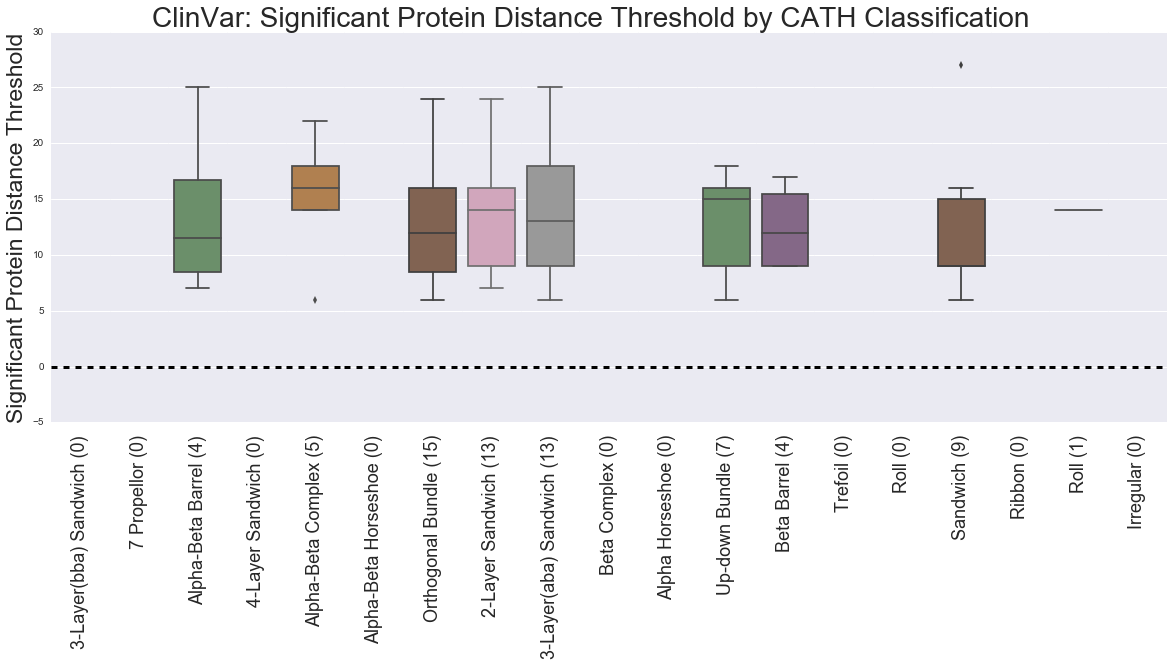


~4 outliers not shown.
ANOVA: F=0.148584; p=0.996


In [23]:
# Setup the plot
fig,ax = plt.subplots(1,len(cath),figsize=(20,7),sharey=True,facecolor='white')
plt.subplots_adjust(wspace=0, hspace=0)
pal = list(sns.color_palette("Set1", n_colors=len(cath), desat=.5))

subs = [df.ix[(df["CATH"]==cath[i]) & (df["q"]<0.1),"t"] for i in range(len(cath))]
for i,s in enumerate(subs):
    # Boxplot for each CATH class
    sns.boxplot(s,color=pal[i],ax=ax[i],orient='vertical')
    ax[i].set_xlabel("%s (%d)"%(cathn[i],len(s)),fontsize=18,rotation='vertical')
    ax[i].set_ylabel("")
    
plt.rcParams['xtick.labelsize'] = 20
ax[0].set_ylabel("Significant Protein Distance Threshold",fontsize=23)
for x in ax:
    x.axhline(y=0,c='k',ls='dashed',lw=3)
plt.suptitle("ClinVar: Significant Protein Distance Threshold by CATH Classification",fontsize=28,y=0.95)
plt.show()

print "\n~4 outliers not shown."
print "ANOVA: F=%g; p=%.3g"%f_oneway(*[s.dropna() for s in subs if len(s.dropna())])